# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#7E8083   ; overflow:hidden"><b>Import libraries and load data</b></div>

In [80]:
import os
import pandas as pd 
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [81]:
dir = '/root/workspace/forecast/data/predict/dataset/10k-15k'


def count_files_in_directory(directory):
    i = 0
    # 获取目录下的所有文件和文件夹
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file():
                df = pd.read_csv(entry)
                if len(df) < 10:
                    continue
                i += 1

                # Shift the 'Commit Count' column up by one and assign it to 'target' column
                df['Target'] = df['Commit Count'].shift(-1)
                df['Target'] = df['Target'].fillna(df['Commit Count'])

                if 'tensor_list' not in locals():
                    tensor_list = df
                else:
                    tensor_list = pd.concat([tensor_list, df], ignore_index=True)
    print(i)

    return tensor_list

In [82]:
all = count_files_in_directory(dir)

20


In [125]:
from pandas import get_dummies

data = all.copy().drop(columns=['Core Developers Focus Rate'])
# data['Target'] = data['Target'].apply(lambda x: ast.literal_eval(x)[0] if x != '[]' else 0)

# 计算变化百分比
# data['Target'] = (data['Target'] - data['Commit Count']) / data['Commit Count']

# 创建新列，根据变化比例进行分类
# def categorize_change(row):
#     if abs(row['Target']) > 0.3:  # 超过30%
#         return 1 if row['Target'] > 0 else 0
#     else:
#         return 2  # 未超过30%

# get_dummies(data['Target'], prefix='Target')


# data['code_per_file'] = data['Code Lines'] / data['Code Files']
# data = data[data['Target'] < 400]
data = data[data['Develop Time'] > 0]

# data['code_line_delta'] = data['Added Code Lines'] - data['Removed Code Lines']
# data['code_per_commit'] = (data['Added Code Lines'] + abs(data['Removed Code Lines'])) / data['Commit Count']

data["Fork Count"] = data["Fork Count"].apply(lambda x: x if x != 0 else 1)
data["Modified File Count (Average)"] = data["Modified File Count (Average)"].astype(int)

data["PR Length"] = data["PR Length"].astype(int)
data["PR Length"] = data["PR Length"].replace(0, np.nan)
data["Created PRs"] = data["Created PRs"].replace(0, np.nan)
data["Closed PRs"] = data["Closed PRs"].replace(0, np.nan)
data["Created Issues"] = data["Created Issues"].replace(0, np.nan)
data["Closed Issues"] = data["Closed Issues"].replace(0, np.nan)

data = data.replace(np.inf, np.nan)

data = data.apply(lambda x: x.fillna(x.mean()), axis=0)
data["PR Length"] = data["PR Length"].astype(int)
data["Created PRs"] = data["Created PRs"].astype(int)
data["Closed PRs"] = data["Closed PRs"].astype(int)
data["Created Issues"] = data["Created Issues"].astype(int)
data["Closed Issues"] = data["Closed Issues"].astype(int)
data["Label Counts (Average)"] = data["Label Counts (Average)"].astype(int)
data["Target"] = data["Target"].astype(int)

# # data["PR Length"] = data["PR Length"].astype(int)

data = data.drop(columns=['Bot Commit', 
                          'Reopened Issues', 
                          'Release Count','Download Count', 
                          'Markdown Files', 'Markdown Lines',
                          'Code Files', 'Code Lines',
                          'Bot Commit', 'Truck Factor',
                          'Code Comments',
                          "PR Length"])

# data = data.drop(columns=['Commit Count'])


array([[<Axes: title={'center': 'Commit Count'}>,
        <Axes: title={'center': 'Modified File Count (Average)'}>,
        <Axes: title={'center': 'Created Issues'}>,
        <Axes: title={'center': 'Closed Issues'}>],
       [<Axes: title={'center': 'Label Counts (Average)'}>,
        <Axes: title={'center': 'Created PRs'}>,
        <Axes: title={'center': 'Closed PRs'}>,
        <Axes: title={'center': 'Added Code Lines'}>],
       [<Axes: title={'center': 'Removed Code Lines'}>,
        <Axes: title={'center': 'Fork Count'}>,
        <Axes: title={'center': 'Develop Time'}>,
        <Axes: title={'center': 'Star'}>],
       [<Axes: title={'center': 'Target'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

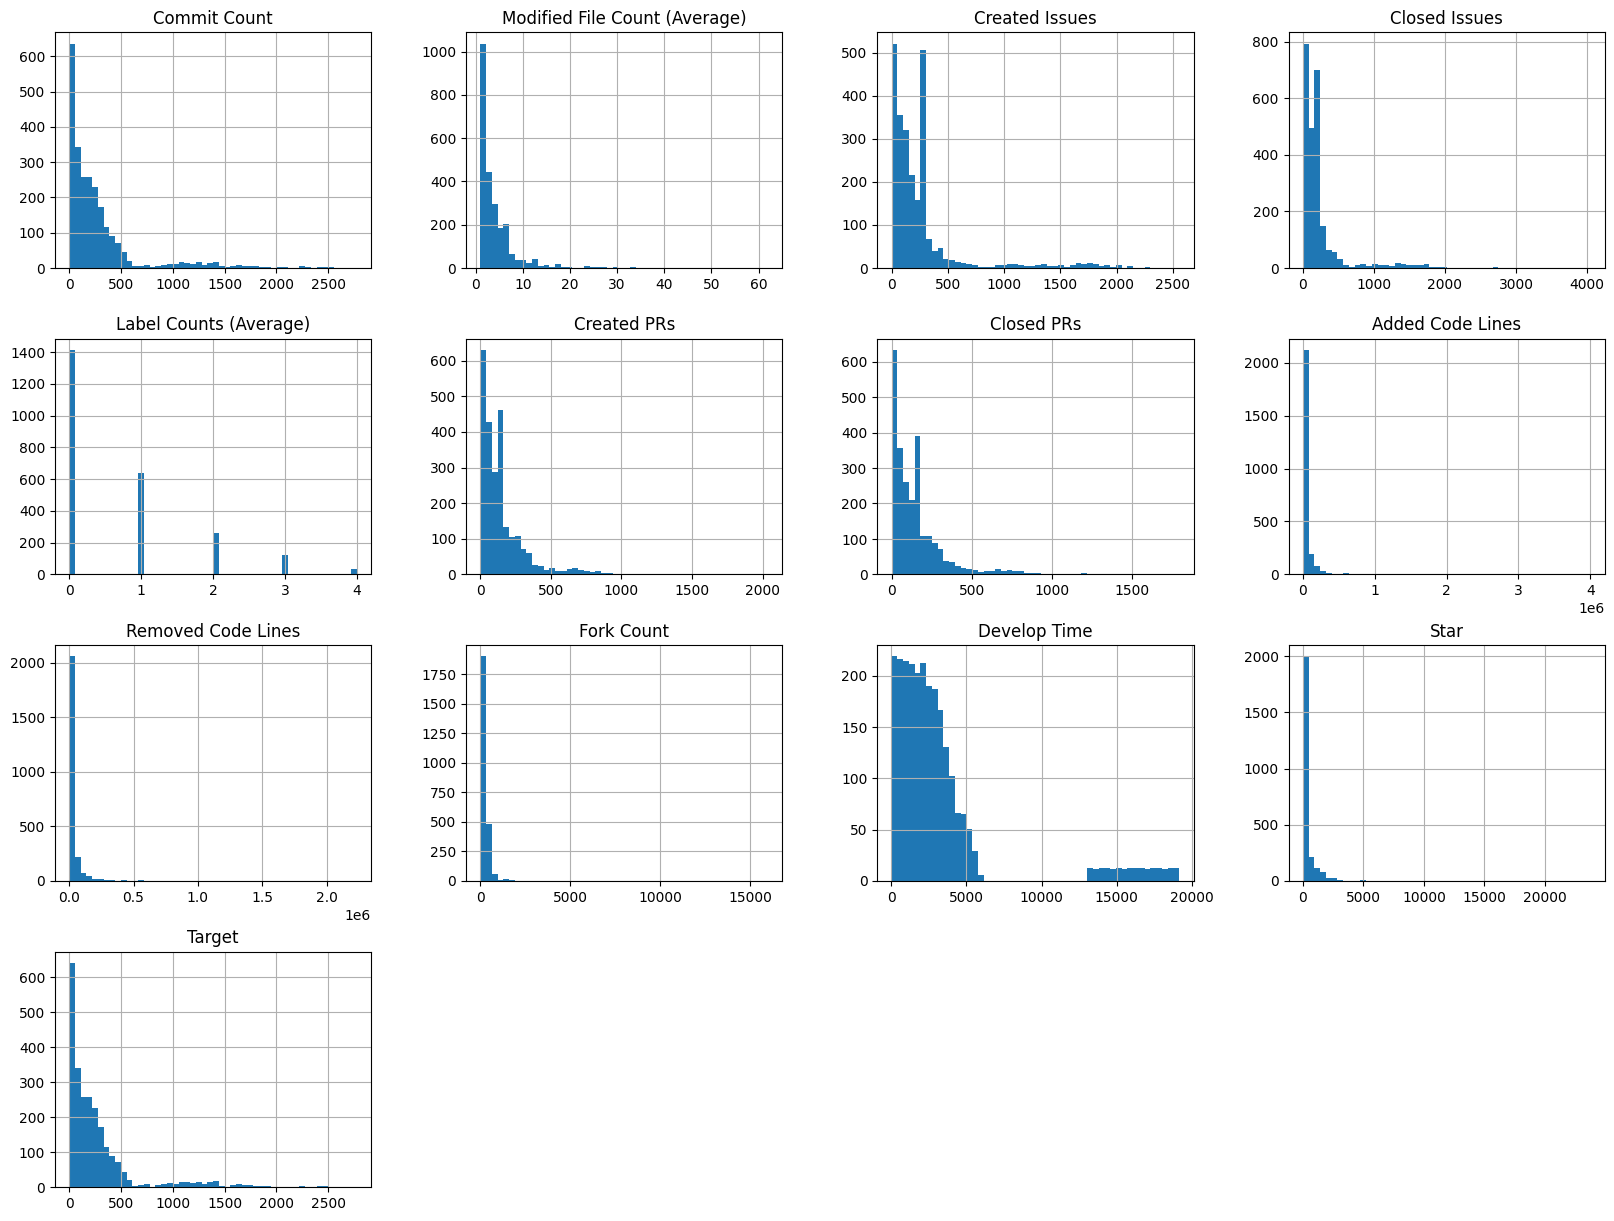

In [126]:
data.hist(bins=50, figsize=(20,15))

In [127]:
# 分离特征和目标变量
features = data.drop("Target", axis=1)
target = data["Target"].copy()

from sklearn.impute import SimpleImputer

# 使用中位数填补缺失值
imputer = SimpleImputer(strategy="median")
numeric_features = features.select_dtypes(include=[np.number])
imputer.fit(numeric_features)
features_imputed = imputer.transform(numeric_features)

from sklearn.ensemble import IsolationForest

# 使用IsolationForest进行异常值检测
isolation_forest = IsolationForest(random_state=42)
outlier_predictions = isolation_forest.fit_predict(features_imputed)

# 过滤掉异常值
features_filtered = features.iloc[outlier_predictions == 1]
target_filtered = target.iloc[outlier_predictions == 1]

array([[<Axes: title={'center': 'Commit Count'}>,
        <Axes: title={'center': 'Modified File Count (Average)'}>,
        <Axes: title={'center': 'Created Issues'}>],
       [<Axes: title={'center': 'Closed Issues'}>,
        <Axes: title={'center': 'Label Counts (Average)'}>,
        <Axes: title={'center': 'Created PRs'}>],
       [<Axes: title={'center': 'Closed PRs'}>,
        <Axes: title={'center': 'Added Code Lines'}>,
        <Axes: title={'center': 'Removed Code Lines'}>],
       [<Axes: title={'center': 'Fork Count'}>,
        <Axes: title={'center': 'Develop Time'}>,
        <Axes: title={'center': 'Star'}>]], dtype=object)

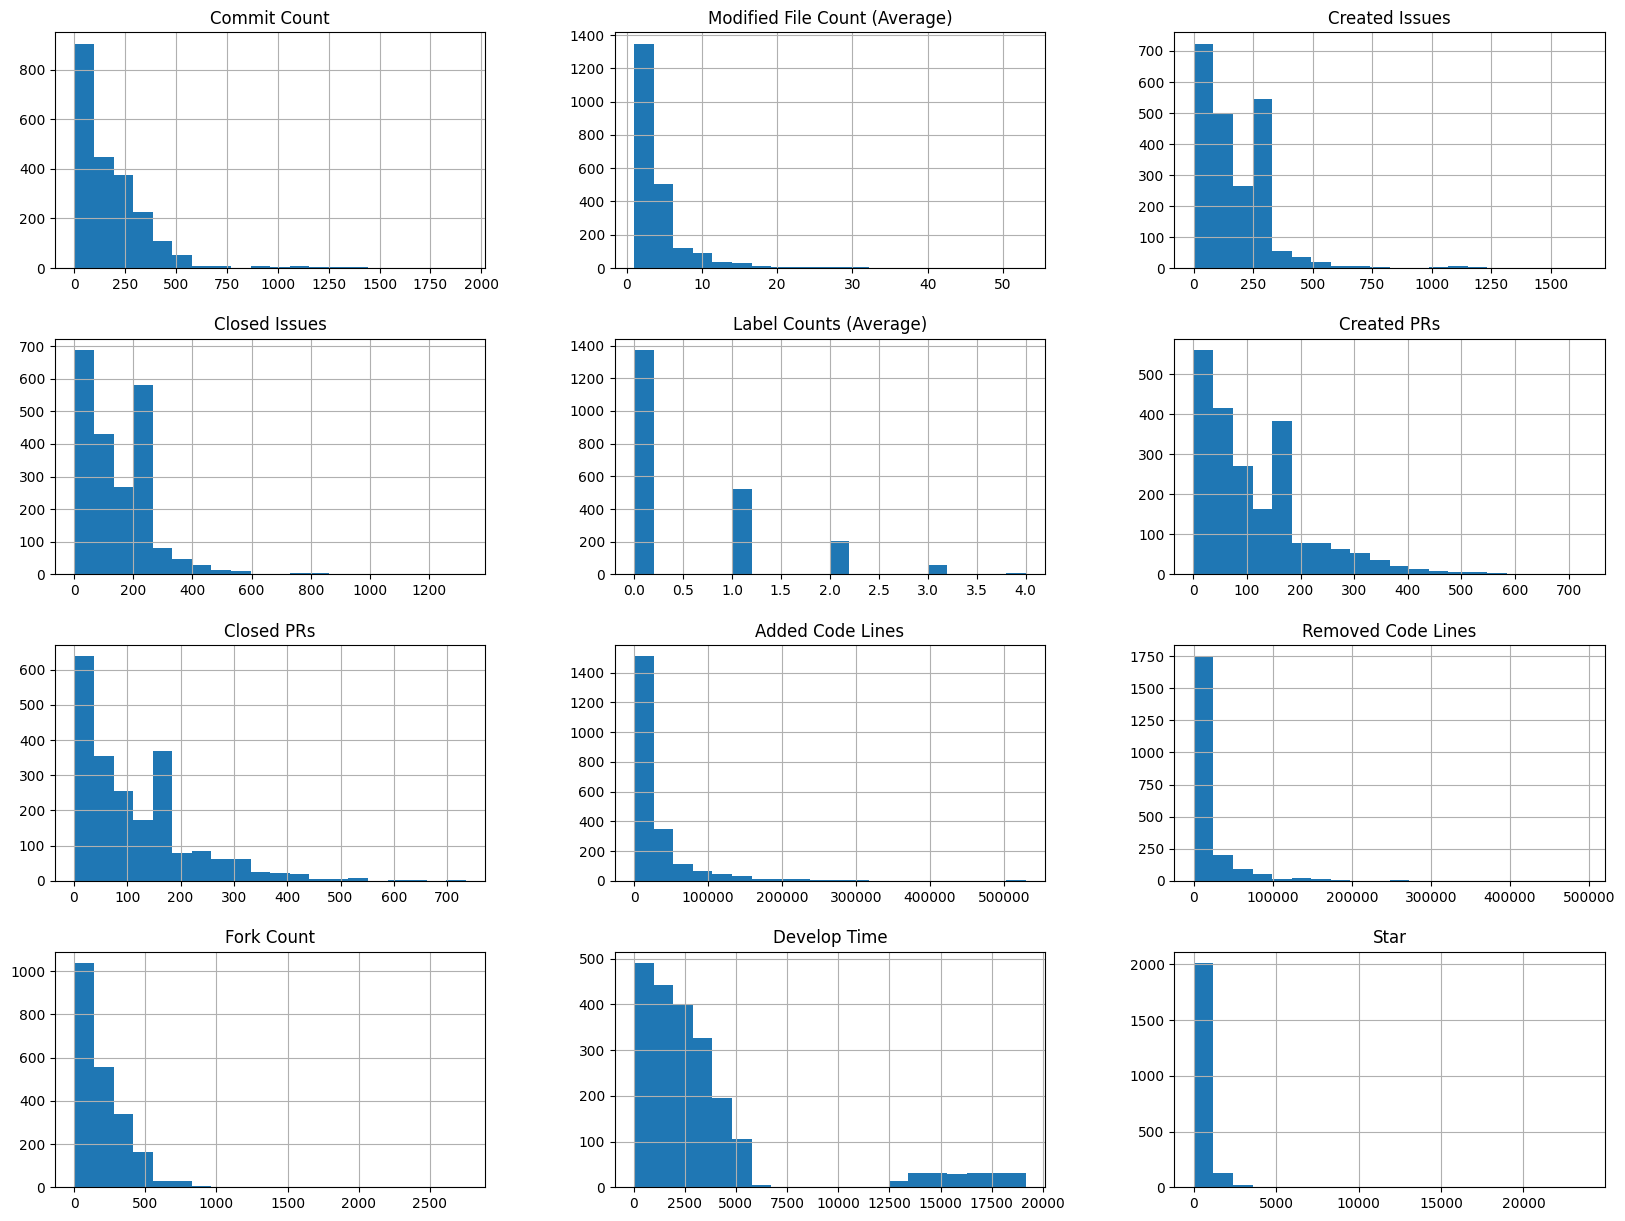

In [128]:
features_filtered.hist(bins=20, figsize=(20,15))

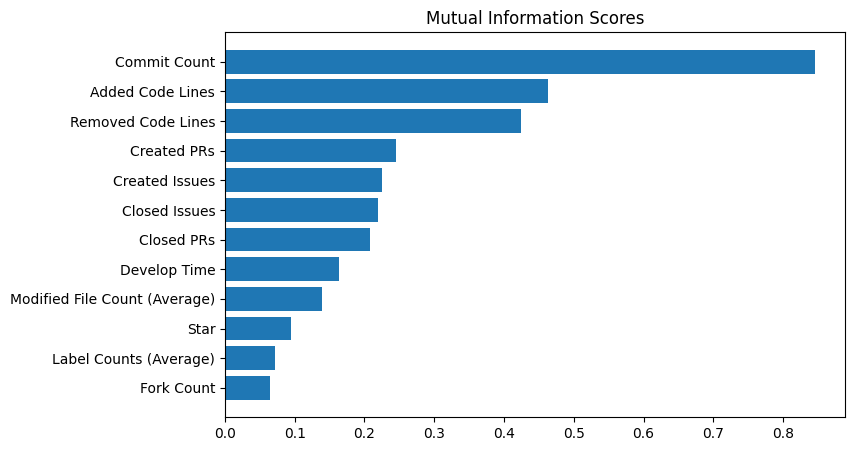

In [129]:
for colname in data.select_dtypes("object"):
    data[colname], _ = data[colname].factorize()
    
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(features_filtered, target_filtered)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#7E8083   ; overflow:hidden"><b>Model</b></div>

In [130]:
X = features_filtered.copy()
Y = target_filtered.copy()

# # Remove classes with fewer than 2 instances
# class_counts = Y.value_counts()
# to_keep = class_counts[class_counts >= 2].index
# X = X[Y.isin(to_keep)]
# Y = Y[Y.isin(to_keep)]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

rus = RandomOverSampler(random_state=42)
X, Y = rus.fit_resample(X_train, Y_train)

<Axes: xlabel='Target', ylabel='Count'>

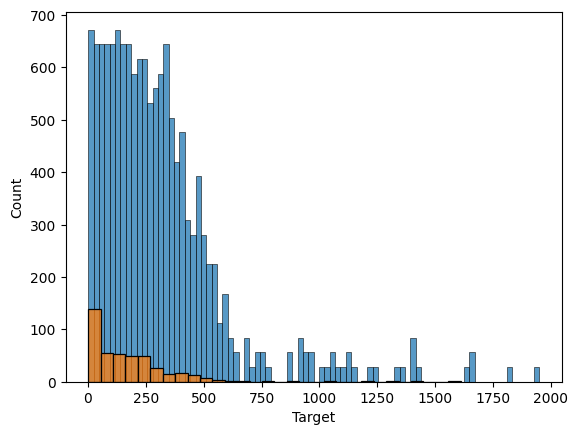

In [131]:
sns.histplot(Y)
sns.histplot(Y_test)

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler ()),
])

In [133]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeRegressor


model = RandomForestRegressor(n_estimators=1000, random_state=42)
pip = make_pipeline(num_pipeline, model)
pip.fit(X_train, Y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                                 ('standardize', StandardScaler())])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=1000, random_state=42))])

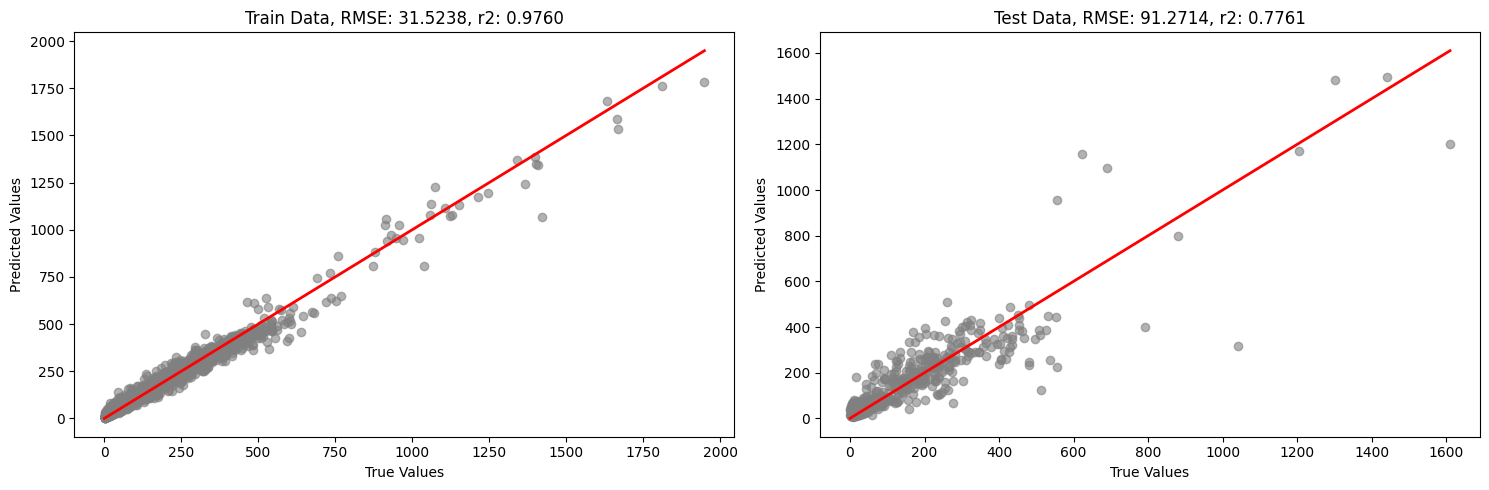

In [134]:
y_pred_i = pip.predict(X_train)
base = Y_train.loc[::]
pred = y_pred_i[::]
accuracy = (base == pred).mean()
mse = root_mean_squared_error(base, pred)
r2 = r2_score(base, pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(base, pred, color='grey', alpha=0.6)
axes[0].plot([0, base.max()], [0, base.max()], color='red', lw=2)
axes[0].set_title(f'Train Data, RMSE: {mse:.4f}, r2: {r2:.4f}')
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')

y_pred_i = pip.predict(X_test)
base = Y_test.loc[::]
pred = y_pred_i[::]
accuracy = (base == pred).mean()
mse = root_mean_squared_error(base, pred)
r2 = r2_score(base, pred)


axes[1].scatter(base, pred, color='grey', alpha=0.6)
axes[1].plot([0, base.max()], [0, base.max()], color='red', lw=2)
axes[1].set_title(f'Test Data, RMSE: {mse:.4f}, r2: {r2:.4f}')
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [ ]:
import shap
explainer = shap.Explainer(pip.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values)

PermutationExplainer explainer:  59%|█████▉    | 255/434 [16:41<11:51,  3.97s/it]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch.nn.functional as F

X = features_filtered.copy()
y = target_filtered.copy()

# 数据预处理
scaler = StandardScaler()
X = scaler.fit_transform(X)

# # 多项式特征（可选）

# 数据划分
# 删除少于2的类
# class_counts = y.value_counts()
# to_keep = class_counts[class_counts >= 2].index
# X = X[np.isin(y, to_keep)]
# y = y[np.isin(y, to_keep)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [254]:
X_train_tensor.size()

torch.Size([1704, 13])

In [255]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化 LSTM 隐状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 隐藏状态
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 细胞状态

        # LSTM 前向传播
        out, _ = self.lstm(x, (h0, c0))  # 输出的维度是 (batch_size, seq_length, hidden_size)

        # 取最后一个时间步的输出
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # 全连接层
        out = self.fc(out)  # (batch_size, output_size)
        return out


In [256]:
# 超参数
input_size = X_train.shape[1]  # 输入特征数
output_size = 1                # 输出维度（回归任务为 1）
hidden_size = 128  # 增加隐藏层大小
num_layers = 3     # 增加 LSTM 层数
learning_rate = 0.0005  # 减小学习率
num_epochs = 500

# 实例化模型
model = SimpleNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()  # 损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model

SimpleNN(
  (lstm): LSTM(13, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [257]:
model.train()
for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:
        # 调整输入维度为 (batch_size, seq_length, input_size)
        batch_x = batch_x.unsqueeze(1)  # 添加时间步维度
        batch_y = batch_y.unsqueeze(1)  # 保证目标维度一致

        # 前向传播
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 打印每个 epoch 的损失
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [5/500], Loss: 37498.6953
Epoch [10/500], Loss: 36179.0039
Epoch [15/500], Loss: 59924.2383
Epoch [20/500], Loss: 15418.8496
Epoch [25/500], Loss: 15826.6143
Epoch [30/500], Loss: 18993.1719
Epoch [35/500], Loss: 18863.1445
Epoch [40/500], Loss: 21395.4570
Epoch [45/500], Loss: 15419.7705
Epoch [50/500], Loss: 18801.5664
Epoch [55/500], Loss: 25121.0742
Epoch [60/500], Loss: 26709.6758
Epoch [65/500], Loss: 10369.4961
Epoch [70/500], Loss: 10737.5254
Epoch [75/500], Loss: 12152.6270
Epoch [80/500], Loss: 16249.6777
Epoch [85/500], Loss: 14694.5811
Epoch [90/500], Loss: 13133.0605
Epoch [95/500], Loss: 10669.3232
Epoch [100/500], Loss: 12584.6670
Epoch [105/500], Loss: 11800.6289
Epoch [110/500], Loss: 18557.2930
Epoch [115/500], Loss: 12202.0801
Epoch [120/500], Loss: 9037.0312
Epoch [125/500], Loss: 21489.9844
Epoch [130/500], Loss: 3767.9263
Epoch [135/500], Loss: 8225.2578
Epoch [140/500], Loss: 12518.4365
Epoch [145/500], Loss: 14012.6250
Epoch [150/500], Loss: 13673.3066
Epo

In [260]:
model.eval()

X_train_tensor = X_train_tensor.unsqueeze(1)  # 添加时间步维度
y_train_tensor = y_train_tensor.unsqueeze(1)  # 保证目标维度一致

with torch.no_grad():
    y_pred_tensor = model(X_train_tensor)
    y_pred = y_pred_tensor.numpy()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train data scatter plot
axes[0].scatter(y_train_tensor, y_pred, alpha=0.5)
axes[0].plot([min(y_train_tensor), max(y_train_tensor)], [min(y_train_tensor), max(y_train_tensor)], color='red', linestyle='--')
axes[0].set_title('True vs Predicted Values (Train Data) MSE={:.4f}'.format(criterion(y_pred_tensor, y_train_tensor)))
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')
axes[0].grid()

X_test_tensor = X_test_tensor.unsqueeze(1)  # 添加时间步维度
y_test_tensor = y_test_tensor.unsqueeze(1)  # 保证目标维度一致

with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

# Test data scatter plot
axes[1].scatter(y_test_tensor, y_pred, alpha=0.5)
axes[1].plot([min(y_test_tensor), max(y_test_tensor)], [min(y_test_tensor), max(y_test_tensor)], color='red', linestyle='--')
axes[1].set_title('True vs Predicted Values (Test Data) MSE={:.4f}'.format(criterion(y_pred_tensor, y_test_tensor)))
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')
axes[1].grid()


plt.tight_layout()
plt.show()


ValueError: LSTM: Expected input to be 2D or 3D, got 5D instead